In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from utils_0 import *
import scipy.io as sio

In [2]:
data = sio.loadmat('DATA/heat_centersource_1000Hz_2sec_64x_0to1.mat')
U = data['sol']
U1 = U[:800]
dt = 2/2000
nx, ny = 64, 64
t = np.arange(0, 2, dt)
x = np.linspace(-2, 2, nx)
y = np.linspace(-2, 2, ny)
dx = x[1]-x[0]
dt = t[1]-t[0]
dy = y[1]-y[0]

In [3]:
n = len(x)
# steps = len(t)

# Sample a collection of data points.  See figure 1 panel 2a.
np.random.seed(0) # so that numbers in paper are reproducible

num_xy = 5000 # needs to be very high to work with noise
num_t = 80
num_points = num_xy * num_t
boundary = 5
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    y = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,6*t+10]
        count = count + 1 

In [4]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    # value of function
    u[p] = U1[t,x,y]
    # time derivatives
    ut[p] = PolyDiffPoint(U1[t-(Nt-1)//2:t+(Nt+1)//2,x,y], np.arange(Nt)*dt, deg, 1)[0]
    # spatial derivatives
    ux_diff = PolyDiffPoint(U1[t,x-(N-1)//2:x+(N+1)//2,y], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(U1[t,x,y-(N-1)//2:y+(N+1)//2], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(U1[t,x-(N-1)//2:x+(N+1)//2,y+1], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(U1[t,x-(N-1)//2:x+(N+1)//2,y-1], np.arange(N)*dx, deg, 2)
    
    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]

# Form Theta using up to quadratic polynomials in all variables.
X_data = u
X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}']

In [5]:
X_data = np.reshape(X_data, -1)
DICT_1 = DICT_FUNC(X_ders, X_data, num_points)
DICT_1 = DICT_1.T

## SINDy

In [6]:
sindy_time_1 = time.time()

dxdt = np.column_stack(( ut ))
lam = 0.9 
Xi = sindy(lam,DICT_1,dxdt)
print(Xi)

theta = []
for i in Xi:
    if (i.real[0])!=0:
        theta.append(1)
    else:
        theta.append(0)

[[0.        ]
 [0.        ]
 [0.        ]
 [1.00021296]
 [0.        ]
 [1.0001385 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


In [7]:
True_theta = np.zeros(len(theta))
True_theta[3] = 1
True_theta[5] = 1

In [8]:
print('SINDy L2 (0% noise)  :',np.linalg.norm(True_theta - Xi.reshape(-1))/np.linalg.norm(True_theta) )

SINDy L2 (0% noise)  : 0.00017963155422244574


## Variational Bayes

In [10]:
tol = 0.0001
verbosity = True
initz0 = theta
xdts = np.reshape(ut, -1)
DS = Variational_Bayes_Code_2d(DICT_1, xdts, initz0, tol, verbosity)
print('zmean  ',  DS['zmean'])
print('model_Index  ',DS['modelIdx'])
print('Wsel  ', DS['Wsel'])
print('Wcov  ', DS['Wcov'])

/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[Kalpesh]Bayes_PDE_discovery/Github/utils_0.py:846: RuntimeWarning: overflow encountered in exp
  expitC = 1./(1 + np.exp(-C))
/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[Kalpesh]Bayes_PDE_discovery/Github/utils_0.py:818: RuntimeWarning: divide by zero encountered in log
  + np.nansum(zm*(np.log(p0) - np.log(zm)))
/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[Kalpesh]Bayes_PDE_discovery/Github/utils_0.py:818: RuntimeWarning: invalid value encountered in multiply
  + np.nansum(zm*(np.log(p0) - np.log(zm)))
/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[Kalpesh]Bayes_PDE_discovery/Github/utils_0.py:819: RuntimeWarning: divide by zero encountered in log
  + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))
/home/user/Desktop/Colaborations/Yogesh and Kalpesh/[Kalpesh]Bayes_PDE_discovery/Github/utils_0.py:819: RuntimeWarning: invalid value encountered in multiply
  + np.nansum((1-zm)*(np.log(1-p0) - np.log(1-zm))))


Iteration = 0  log(Likelihood) = 1833301.1717867816
Iteration = 1  log(Likelihood) = 1836154.998441579
Iteration = 2  log(Likelihood) = 1836155.0004044815
Iteration = 3  log(Likelihood) = 1836155.000405794
zmean   [1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
model_Index   [2 4]
Wsel   [1.00020967 1.00013492]
Wcov   [2.29367989e-10 2.29986530e-10]


In [11]:
print('Theta :',DS['Wsel'])
vb_theta = DS['wmean']
vb_theta[0] = 0
nl = DICT_1.shape[1]
zmean = DS['zmean']
zmean[0] = 0
print('VB L2 (0% noise)  :',np.linalg.norm(True_theta - vb_theta.reshape(-1))/np.linalg.norm(True_theta) )

Theta : [1.00020967 1.00013492]
VB L2 (0% noise)  : 0.00017630158180339397


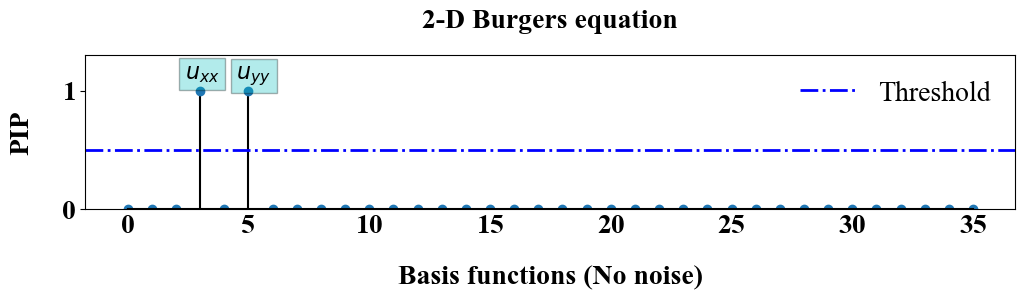

In [12]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

figure1 = plt.figure(figsize=(12, 2))
xr = np.array(range(nl))

plt.stem(xr, zmean, linefmt='k-', markerfmt='o', basefmt='k-', use_line_collection=True)
plt.axhline(y=0.5, color='b', linestyle='-.', linewidth=2, label='Threshold')

plt.xlabel('Basis functions (No noise)', fontweight='bold', labelpad=20)
plt.ylabel('PIP', fontweight='bold', labelpad=20)
plt.title('2-D Burgers equation', fontweight='bold', fontsize=20, pad=20)
plt.grid(False)
plt.ylim(0, 1.3)

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.tick_params(axis='x', which='both', length=0)

plt.text(3.8, 1.1, '$u_{xx}$', bbox=dict(facecolor='c', alpha=0.3), fontsize=16, ha='right')
plt.text(4.5, 1.1, '$u_{yy}$', bbox=dict(facecolor='c', alpha=0.3), fontsize=16)

plt.legend(loc='upper right', frameon=False, fontsize=20)
plt.show()


# 1% Noise

In [13]:
np.random.seed(0)
m1, n1, o1 = U1.shape[0], U1.shape[1], U1.shape[2]
Un1 = U1 + 0.01*np.std(U1)*np.random.randn(m1,n1,o1)
# Denoise using POD.
FUn1 = np.reshape(Un1, (m1,n1*o1), order='F')
uun1,usn1,uvn1 = np.linalg.svd(FUn1, full_matrices = False)
dim = 15
# num_points = 1000
UN1 = np.reshape(uun1[:,:dim].dot(np.diag(usn1[:dim]).dot(uvn1[:dim,:])), (m1, n1, o1), order='F')
# utn1, X_datan1, X_dersn1, X_ders_descrn1 = INITIAL_DERIV(Un1)


In [14]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    # value of function
    u[p] = UN1[t,x,y]
    # time derivatives
    ut[p] = PolyDiffPoint(UN1[t-(Nt-1)//2:t+(Nt+1)//2,x,y], np.arange(Nt)*dt, deg, 1)[0]
    # spatial derivatives
    ux_diff = PolyDiffPoint(UN1[t,x-(N-1)//2:x+(N+1)//2,y], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(UN1[t,x,y-(N-1)//2:y+(N+1)//2], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(UN1[t,x-(N-1)//2:x+(N+1)//2,y+1], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(UN1[t,x-(N-1)//2:x+(N+1)//2,y-1], np.arange(N)*dx, deg, 2)
    
    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]

# Form Theta using up to quadratic polynomials in all variables.
X_datan1 = u
utn1 = ut
X_dersn1 = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy])
X_ders_descrn1 = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}']

In [15]:
X_datan1 = np.reshape(X_datan1, -1)
DICT_n1 = DICT_FUNC(X_dersn1, X_datan1, num_points)
DICT_n1 = DICT_n1.T

## SINDy

In [16]:
dxdt = np.column_stack(( utn1 ))
lam = 0.9 
Xi_n1 = sindy(lam,DICT_n1,dxdt)
print(Xi_n1)

theta = []
for i in Xi_n1:
    if (i.real[0])!=0:
        theta.append(1)
    else:
        theta.append(0)
print('SINDy L2 (1% noise)  :',np.linalg.norm(True_theta - Xi_n1.reshape(-1))/np.linalg.norm(True_theta) )

[[  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.9930413 ]
 [  0.        ]
 [  0.99288415]
 [  0.        ]
 [ -3.2698077 ]
 [ 23.62149414]
 [-37.4601881 ]
 [ 15.2052288 ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  1.56714951]
 [  2.03849151]
 [  0.        ]
 [  0.        ]
 [ -3.5023035 ]
 [ -5.62088252]
 [  0.        ]
 [  0.        ]
 [  1.91041889]
 [  5.05864308]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ -1.61009662]]
SINDy L2 (1% noise)  : 33.80410654703093


## Variational Bayes

In [18]:
tol = 0.0001
verbosity = True
initz0 = theta
xdts = np.reshape(utn1, -1)
DS = Variational_Bayes_Code_2d(DICT_n1, xdts, initz0, tol, verbosity)

print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])

Iteration = 0  log(Likelihood) = 867517.5192027743
Iteration = 1  log(Likelihood) = 867518.2277997972
Iteration = 2  log(Likelihood) = 867518.2277998307
DS['zmean']  => [1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1]
DS['wmean']  => [ 2.05757903e-04  0.00000000e+00  0.00000000e+00  9.95713554e-01
  0.00000000e+00  9.96193555e-01  0.00000000e+00 -1.41336003e-01
  6.10182979e-01  3.38256974e-01  1.48157499e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.32754565e-01  1.93202184e-01
  0.00000000e+00  0.00000000e+00 -6.76204162e-02 -1.68004790e-01
  0.00000000e+00  0.00000000e+00  3.12545253e-03 -6.95286532e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.61760566e-02]
DS['Wsel']   => [ 0.99571355  0.99619356 -0.141336    0.61018298  0.33825697  0.1481575
  0.13275456  0.19320218 -0.06762042 -0.16800479  0.00312545 -0.069

In [19]:
DS['zmean'][np.where(np.diag(DS['wCOV'])>3e-6)] = 0 
DS['wmean'][np.where(np.diag(DS['wCOV'])>3e-6)] = 0 
zmean_1 = DS['zmean']
zmean_1[0] = 0
index_1 = zmean_1

Iteration = 0  log(Likelihood) = 867166.6671343597
Iteration = 1  log(Likelihood) = 867167.3656954695
Iteration = 2  log(Likelihood) = 867167.365695477
DS['zmean']  => [1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DS['wmean']  => [1.09542822e-04 0.00000000e+00 0.00000000e+00 9.99583681e-01
 0.00000000e+00 1.00029752e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
DS['Wsel']   => [0.99958368 1.00029752]
DS['Wcov']   => [2.91125562e-08 2.91840842e-08]


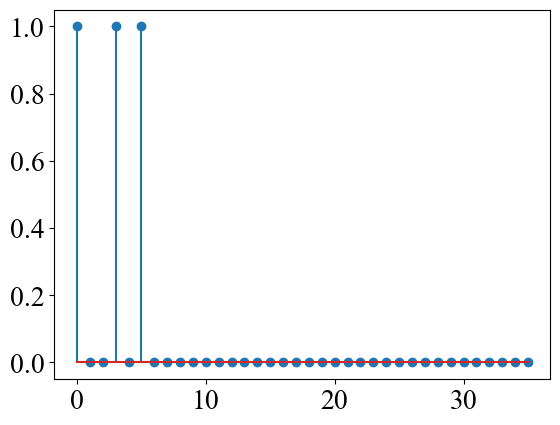

In [21]:
tol = 0.0001
verbosity = True
initz0 = index_1
xdts = np.reshape(utn1, -1)
DS_1 = Variational_Bayes_Code_2d(DICT_n1, xdts, initz0, tol, verbosity)
print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS_1['zmean'])

plt.show()

In [22]:
print('Theta :',DS['Wsel'])
vb_theta_n1 = DS['wmean']
vb_theta_n1[0] = 0
zmean_n1 = DS['zmean']
zmean_n1[0] = 0
print('VB L2 (1% noise)  :',np.linalg.norm(True_theta - vb_theta_n1.reshape(-1))/np.linalg.norm(True_theta) )

Theta : [0.99958368 1.00029752]
VB L2 (1% noise)  : 0.0003618288779709368


# 2% Noise

In [23]:
np.random.seed(0)
m1, n1, o1 = U1.shape[0], U1.shape[1], U1.shape[2]
Un2 = U1 + 0.02*np.std(U1)*np.random.randn(m1,n1,o1)

# Denoise using POD.
FUn2 = np.reshape(Un2, (m1,n1*o1), order='F')
uun2,usn2,uvn2 = np.linalg.svd(FUn2, full_matrices = False)

dim = 15
UN2 = np.reshape(uun2[:,:dim].dot(np.diag(usn2[:dim]).dot(uvn2[:dim,:])), (m1, n1, o1), order='F')

# utn2, X_datan2, X_dersn2, X_ders_descrn2 = INITIAL_DERIV(UN2)


In [24]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    # value of function
    u[p] = UN2[t,x,y]
    # time derivatives
    ut[p] = PolyDiffPoint(UN2[t-(Nt-1)//2:t+(Nt+1)//2,x,y], np.arange(Nt)*dt, deg, 1)[0]
    # spatial derivatives
    ux_diff = PolyDiffPoint(UN2[t,x-(N-1)//2:x+(N+1)//2,y], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(UN2[t,x,y-(N-1)//2:y+(N+1)//2], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(UN2[t,x-(N-1)//2:x+(N+1)//2,y+1], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(UN2[t,x-(N-1)//2:x+(N+1)//2,y-1], np.arange(N)*dx, deg, 2)
    
    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]

# Form Theta using up to quadratic polynomials in all variables.
X_datan2 = u
utn2 = ut
X_dersn2 = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy])
X_ders_descrn2 = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}']

In [25]:
X_datan2 = np.reshape(X_datan2, -1)
DICT_n2 = DICT_FUNC(X_dersn2, X_datan2, num_points)
DICT_n2 = DICT_n2.T


## SINDy

In [26]:
dxdt = np.column_stack(( utn2 ))
lam = 0.8 
Xi_n2 = sindy(lam,DICT_n2,dxdt)
print(Xi_n2)

theta = []
for i in Xi_n2:
    if (i.real[0])!=0:
        theta.append(1)
    else:
        theta.append(0)

[[   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.93917191]
 [   0.        ]
 [   0.93744345]
 [   0.90259169]
 [ -17.89395181]
 [  88.15440768]
 [-129.13068951]
 [  45.78385929]
 [   0.        ]
 [   0.        ]
 [   1.15793858]
 [   0.        ]
 [   1.2249873 ]
 [   0.        ]
 [   0.        ]
 [ -10.06876069]
 [ -10.67325177]
 [   0.        ]
 [  -1.0487614 ]
 [  42.20735013]
 [  44.88543109]
 [   0.        ]
 [   6.1628227 ]
 [ -81.95138095]
 [ -87.52840683]
 [   0.        ]
 [ -11.90067686]
 [  72.64110989]
 [  78.04152571]
 [   0.        ]
 [   7.51257373]
 [ -24.68185124]
 [ -26.78159423]]


In [27]:
print('SINDy L2 (2% noise)  :',np.linalg.norm(True_theta - Xi_n2.reshape(-1))/np.linalg.norm(True_theta) )

SINDy L2 (2% noise)  : 170.5659231421697


## Variational Bayes

Iteration = 0  log(Likelihood) = 579377.7621462005
Iteration = 1  log(Likelihood) = 579388.5711992767
Iteration = 2  log(Likelihood) = 579388.5711993293
DS['zmean']  => [1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
DS['wmean']  => [ 0.00341011  0.          0.          0.9507429   0.          0.95007292
 -0.6708241   2.6056165   0.57434723  0.          0.          0.
  0.          0.35731277  0.          0.36828059  0.          0.
 -0.75683924 -0.75043262  0.          0.          0.75518744  0.7698771
  0.          0.          0.26572747  0.23036216  0.          0.
 -0.21339903 -0.2792492   0.          0.         -0.27189878 -0.34401454]
DS['Wsel']   => [ 0.9507429   0.95007292 -0.6708241   2.6056165   0.57434723  0.35731277
  0.36828059 -0.75683924 -0.75043262  0.75518744  0.7698771   0.26572747
  0.23036216 -0.21339903 -0.2792492  -0.27189878 -0.34401454]
DS['Wcov']   => [1.52492539e-06 1.56913876e-06 7.26717370e-04 1.58647845e-02
 2.81523527e-02 3.33580344

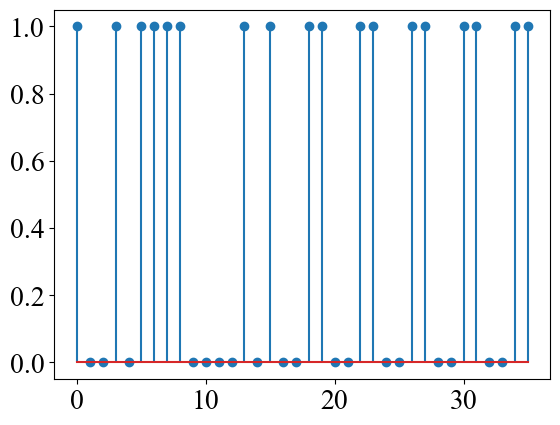

In [28]:
tol = 0.0001
verbosity = True
initz0 = theta
xdts = np.reshape(utn2, -1)
DS = Variational_Bayes_Code_2d(DICT_n2, xdts, initz0, tol, verbosity)

print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS['zmean'])

plt.show()

Iteration = 0  log(Likelihood) = 577627.4877813583
Iteration = 1  log(Likelihood) = 577636.2758633207
Iteration = 2  log(Likelihood) = 577636.2758633491
DS['zmean']  => [1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DS['wmean']  => [1.76478961e-04 0.00000000e+00 0.00000000e+00 9.96978539e-01
 0.00000000e+00 9.98703912e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
DS['Wsel']   => [0.99697854 0.99870391]
DS['Wcov']   => [1.23370097e-07 1.23627470e-07]


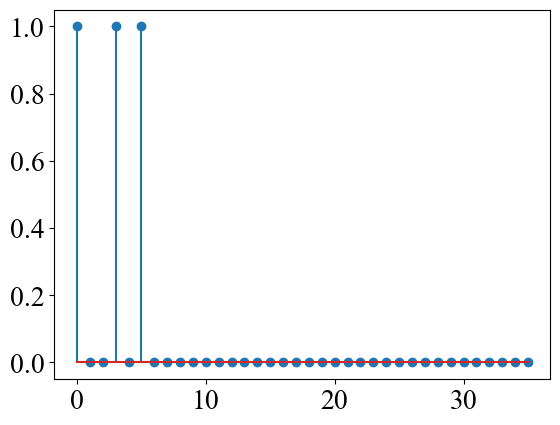

In [29]:
DS['zmean'][np.where(np.diag(DS['wCOV'])>3e-5)] = 0 
DS['wmean'][np.where(np.diag(DS['wCOV'])>3e-5)] = 0 
zmean_1 = DS['zmean']
zmean_1[0] = 0
index_1 = zmean_1
tol = 0.0001
verbosity = True
initz0 = index_1
xdts = np.reshape(utn2, -1)
DS_1 = Variational_Bayes_Code_2d(DICT_n2, xdts, initz0, tol, verbosity)
print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS_1['zmean'])

plt.show()

In [30]:
print('Theta :',DS['Wsel'])
vb_theta_n2 = DS['wmean']
vb_theta_n2[0] = 0
zmean_n2 = DS['zmean']
zmean_n2[0] = 0
print('VB L2 (2% noise)  :',np.linalg.norm(True_theta - vb_theta_n2.reshape(-1))/np.linalg.norm(True_theta) )

Theta : [0.99697854 0.99870391]
VB L2 (2% noise)  : 0.0023247654708610107


# 5% Noise

In [31]:
np.random.seed(0)
m1, n1, o1 = U1.shape[0], U1.shape[1], U1.shape[2]
Un5 = U1 + 0.05*np.std(U1)*np.random.randn(m1,n1,o1)
# Denoise using POD.
FUn5 = np.reshape(Un5, (m1,n1*o1), order='F')
uun5,usn5,uvn5 = np.linalg.svd(FUn5, full_matrices = False)

dim = 15
UN5 = np.reshape(uun5[:,:dim].dot(np.diag(usn5[:dim]).dot(uvn5[:dim,:])), (m1, n1, o1), order='F')

# utn5, X_datan5, X_dersn5, X_ders_descrn5 = INITIAL_DERIV(UN5)


In [32]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    # value of function
    u[p] = UN5[t,x,y]
    # time derivatives
    ut[p] = PolyDiffPoint(UN5[t-(Nt-1)//2:t+(Nt+1)//2,x,y], np.arange(Nt)*dt, deg, 1)[0]
    # spatial derivatives
    ux_diff = PolyDiffPoint(UN5[t,x-(N-1)//2:x+(N+1)//2,y], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(UN5[t,x,y-(N-1)//2:y+(N+1)//2], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(UN5[t,x-(N-1)//2:x+(N+1)//2,y+1], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(UN5[t,x-(N-1)//2:x+(N+1)//2,y-1], np.arange(N)*dx, deg, 2)
    
    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]
    

In [33]:
# Form Theta using up to quadratic polynomials in all variables.
X_datan5 = u
utn5 = ut
X_dersn5 = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy])
X_ders_descrn5 = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}']

X_datan5 = np.reshape(X_datan5, -1)
DICT_n5 = DICT_FUNC(X_dersn5, X_datan5, num_points)
DICT_n5 = DICT_n5.T


## SINDy

In [34]:
dxdt = np.column_stack((utn5))
lam = 0.9
Xi_n5 = sindy(lam,DICT_n5,dxdt)
print(Xi_n5)

[[    0.        ]
 [    0.        ]
 [    0.        ]
 [    0.        ]
 [    0.        ]
 [    0.        ]
 [   18.51721837]
 [ -273.59792728]
 [ 1153.54965911]
 [-1711.81300414]
 [  757.33724987]
 [    0.        ]
 [    0.        ]
 [   29.01548373]
 [    0.        ]
 [   28.81317976]
 [    2.46130216]
 [   -4.63496397]
 [ -281.54266085]
 [ -276.16943755]
 [  -23.95286113]
 [   45.06787611]
 [ 1185.87969995]
 [ 1146.55600445]
 [   82.63482176]
 [ -155.77502703]
 [-2396.72622529]
 [-2272.96152309]
 [ -118.89950409]
 [  226.044041  ]
 [ 2304.69761033]
 [ 2129.22359095]
 [   60.34140413]
 [ -116.39870435]
 [ -855.6776178 ]
 [ -763.9409033 ]]


In [35]:
print('SINDy L2 (5% noise)  :',np.linalg.norm(True_theta - Xi_n5.reshape(-1))/np.linalg.norm(True_theta) )

SINDy L2 (5% noise)  : 3871.412179038952


## Variational Bayes

Iteration = 0  log(Likelihood) = 208728.2595799924
Iteration = 1  log(Likelihood) = 208767.92079398385
Iteration = 2  log(Likelihood) = 208767.9207940602
DS['zmean']  => [1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
DS['wmean']  => [ 0.01566112  0.          0.          0.74350042  0.          0.74037724
 -2.491501    7.99053967  0.36947477 -1.12916954 -0.75526004  0.
  0.          1.93370282  0.          1.9569815   0.          0.
 -4.69967933 -4.6423046   0.          0.          3.90878468  3.94387158
  0.          0.          1.5821807   1.46449823  0.          0.
 -0.96107089 -1.16313719  0.          0.         -1.55755686 -1.76869884]
DS['Wsel']   => [ 0.74350042  0.74037724 -2.491501    7.99053967  0.36947477 -1.12916954
 -0.75526004  1.93370282  1.9569815  -4.69967933 -4.6423046   3.90878468
  3.94387158  1.5821807   1.46449823 -0.96107089 -1.16313719 -1.55755686
 -1.76869884]
DS['Wcov']   => [8.30186903e-06 8.49300108e-06 4.57659610e-03 1.01272812e-01

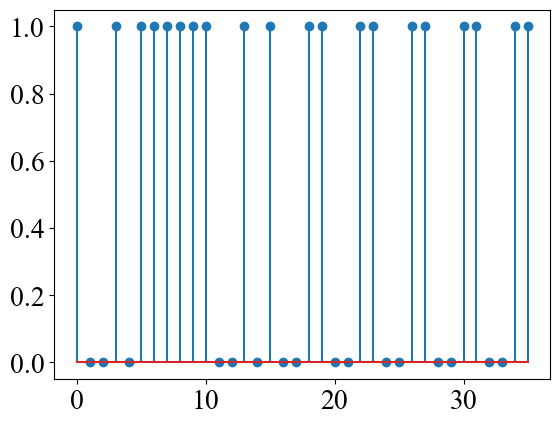

In [36]:
tol = 0.0001
verbosity = True
initz0 = theta
xdts = np.reshape(utn5, -1)
DS = Variational_Bayes_Code_2d(DICT_n5, xdts, initz0, tol, verbosity)

print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS['zmean'])

plt.show()

In [37]:
DS['zmean'][np.where(np.diag(DS['wCOV'])>3e-5)] = 0 
DS['wmean'][np.where(np.diag(DS['wCOV'])>3e-5)] = 0 
zmean_1 = DS['zmean']
zmean_1[0] = 0
index_1 = zmean_1

Iteration = 0  log(Likelihood) = 200829.39300041666
Iteration = 1  log(Likelihood) = 200867.40621306986
Iteration = 2  log(Likelihood) = 200867.40621313773
DS['zmean']  => [1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DS['wmean']  => [-4.85417771e-05  0.00000000e+00  0.00000000e+00  9.77405151e-01
  0.00000000e+00  9.82204494e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
DS['Wsel']   => [0.97740515 0.98220449]
DS['Wcov']   => [7.90994447e-07 7.92042349e-07]


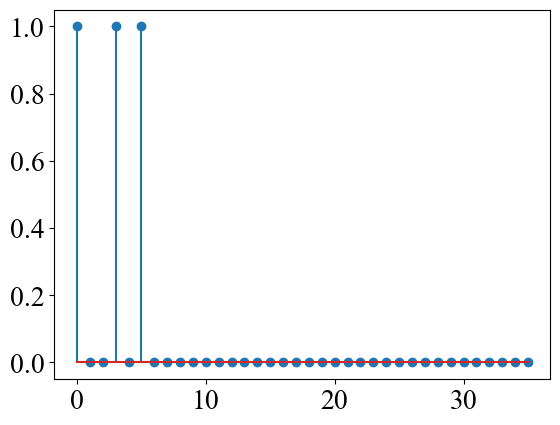

In [39]:
tol = 0.0001
verbosity = True
initz0 = index_1
xdts = np.reshape(utn5, -1)
DS_1 = Variational_Bayes_Code_2d(DICT_n5, xdts, initz0, tol, verbosity)
print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS_1['zmean'])

plt.show()

In [40]:
print('Theta :',DS['Wsel'])
vb_theta_n5 = DS['wmean']
vb_theta_n5[0] = 0
zmean_n5 = DS['zmean']
zmean_n5[0] = 0
print('VB L2 (5% noise)  :',np.linalg.norm(True_theta - vb_theta_n5.reshape(-1))/np.linalg.norm(True_theta) )

Theta : [0.97740515 0.98220449]
VB L2 (5% noise)  : 0.0203372472401332


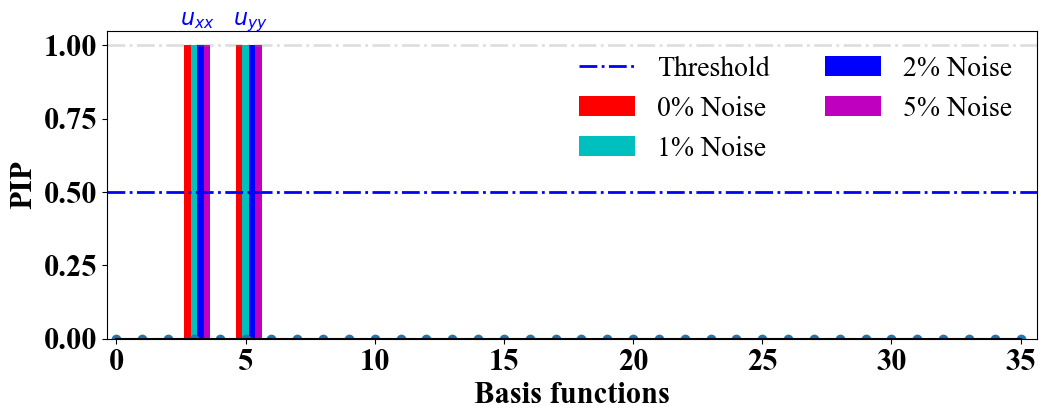

In [48]:
fig = plt.figure(figsize=(12,4))
plt.stem(xr, zmean*0, linefmt='k-', markerfmt='o', basefmt='k-', use_line_collection=True)
plt.bar(xr - 0.25, zmean, color = 'r', width = 0.25, label='0% Noise')
plt.bar(xr + 0.0, zmean_n1, color = 'c', width = 0.25, label='1% Noise')
plt.bar(xr + 0.25, zmean_n2, color = 'b', width = 0.25, label='2% Noise')
plt.bar(xr + 0.50, zmean_n5, color = 'm', width = 0.25, label='5% Noise')
plt.axhline(y=0.5, color='b', linestyle='-.', linewidth=2, label='Threshold')
plt.axhline(y=1.0, color='grey', linestyle='-.', alpha=0.25, linewidth=2)

plt.xlabel('Basis functions', fontweight='bold')
plt.ylabel('PIP', fontweight='bold')
plt.grid(False)
plt.ylim(0, 1.05)

plt.xticks([0, 5, 10, 15, 20, 25, 30, 35], fontweight='bold')
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontweight='bold')
plt.yticks(fontweight='bold')
plt.tick_params(axis='x', which='both')
plt.margins(0)

plt.text(3.8, 1.07, '$u_{xx}$', color='blue', fontsize=16, ha='right')
plt.text(4.5, 1.07, '$u_{yy}$', color='blue', fontsize=16)
plt.legend(loc='upper right', ncol=2, frameon=False, fontsize=20)

plt.show()
fig.savefig('images/2D_Heat_combined.pdf',format='pdf',dpi=600,bbox_inches='tight')

# 10% Noise

In [ ]:
np.random.seed(0)
m1, n1, o1 = U1.shape[0], U1.shape[1], U1.shape[2]
Un10 = U1 + 0.10*np.std(U1)*np.random.randn(m1,n1,o1)
# Denoise using POD.
FUn10 = np.reshape(Un10, (m1,n1*o1), order='F')
uun10,usn10,uvn10 = np.linalg.svd(FUn10, full_matrices = False)

dim = 15
UN10 = np.reshape(uun10[:,:dim].dot(np.diag(usn10[:dim]).dot(uvn10[:dim,:])), (m1, n1, o1), order='F')


In [ ]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    # value of function
    u[p] = UN10[t,x,y]
    # time derivatives
    ut[p] = PolyDiffPoint(UN10[t-(Nt-1)//2:t+(Nt+1)//2,x,y], np.arange(Nt)*dt, deg, 1)[0]
    # spatial derivatives
    ux_diff = PolyDiffPoint(UN10[t,x-(N-1)//2:x+(N+1)//2,y], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(UN10[t,x,y-(N-1)//2:y+(N+1)//2], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(UN10[t,x-(N-1)//2:x+(N+1)//2,y+1], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(UN10[t,x-(N-1)//2:x+(N+1)//2,y-1], np.arange(N)*dx, deg, 2)
    
    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]
    

In [ ]:
# Form Theta using up to quadratic polynomials in all variables.
X_datan10 = u
utn10 = ut
X_dersn10 = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy])
X_ders_descrn10 = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}']

X_datan10 = np.reshape(X_datan10, -1)
DICT_n10 = DICT_FUNC(X_dersn10, X_datan10, num_points)
DICT_n10 = DICT_n10.T


## SINDy

In [ ]:
dxdt = np.column_stack((utn10))
lam = 0.9
Xi_n10 = sindy(lam,DICT_n10,dxdt)
print(Xi_n10)

In [ ]:
print('SINDy L2 (10% noise)  :',np.linalg.norm(True_theta - Xi_n10.reshape(-1))/np.linalg.norm(True_theta) )

## Variational Bayes

In [ ]:
tol = 0.0001
verbosity = True
initz0 = theta
xdts = np.reshape(utn10, -1)
DS = Variational_Bayes_Code_2d(DICT_n10, xdts, initz0, tol, verbosity)

print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS['zmean'])

plt.show()

In [ ]:
DS['zmean'][np.where(np.diag(DS['wCOV'])>3e-5)] = 0 
DS['wmean'][np.where(np.diag(DS['wCOV'])>3e-5)] = 0 
zmean_1 = DS['zmean']
zmean_1[0] = 0
index_1 = zmean_1

In [ ]:
tol = 0.0001
verbosity = True
initz0 = index_1
xdts = np.reshape(utn10, -1)
DS_1 = Variational_Bayes_Code_2d(DICT_n10, xdts, initz0, tol, verbosity)
print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS_1['zmean'])

plt.show()

In [ ]:
print('Theta :',DS['Wsel'])
vb_theta_n10 = DS['wmean']
vb_theta_n10[0] = 0
zmean_n10 = DS['zmean']
zmean_n10[0] = 0
print('VB L2 (10% noise)  :',np.linalg.norm(True_theta - vb_theta_n10.reshape(-1))/np.linalg.norm(True_theta) )

# 15% Noise

In [ ]:
np.random.seed(0)
m1, n1, o1 = U1.shape[0], U1.shape[1], U1.shape[2]
Un15 = U1 + 0.15*np.std(U1)*np.random.randn(m1,n1,o1)

# Denoise using POD.
FUn15 = np.reshape(Un15, (m1,n1*o1), order='F')
uun15,usn15,uvn15 = np.linalg.svd(FUn15, full_matrices = False)

dim = 15
UN15 = np.reshape(uun15[:,:dim].dot(np.diag(usn15[:dim]).dot(uvn15[:dim,:])), (m1, n1, o1), order='F')


In [ ]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    # value of function
    u[p] = UN15[t,x,y]
    # time derivatives
    ut[p] = PolyDiffPoint(UN15[t-(Nt-1)//2:t+(Nt+1)//2,x,y], np.arange(Nt)*dt, deg, 1)[0]
    # spatial derivatives
    ux_diff = PolyDiffPoint(UN15[t,x-(N-1)//2:x+(N+1)//2,y], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(UN15[t,x,y-(N-1)//2:y+(N+1)//2], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(UN15[t,x-(N-1)//2:x+(N+1)//2,y+1], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(UN15[t,x-(N-1)//2:x+(N+1)//2,y-1], np.arange(N)*dx, deg, 2)
    
    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]
    

In [ ]:
# Form Theta using up to quadratic polynomials in all variables.
X_datan15 = u
utn15 = ut
X_dersn15 = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy])
X_ders_descrn15 = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}']

X_datan15 = np.reshape(X_datan15, -1)
DICT_n15 = DICT_FUNC(X_dersn15, X_datan15, num_points)
DICT_n15 = DICT_n15.T


## SINDy

In [ ]:
dxdt = np.column_stack((utn15))
lam = 0.9
Xi_n15 = sindy(lam,DICT_n15,dxdt)
print(Xi_n15)

In [ ]:
print('SINDy L2 (15% noise)  :',np.linalg.norm(True_theta - Xi_n15.reshape(-1))/np.linalg.norm(True_theta) )

## Variational Bayes

In [ ]:
tol = 0.0001
verbosity = True
initz0 = theta
xdts = np.reshape(utn15, -1)
DS = Variational_Bayes_Code_2d(DICT_n15, xdts, initz0, tol, verbosity)

print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS['zmean'])

plt.show()

In [ ]:
tol = 0.0001
verbosity = True
initz0 = index_1
xdts = np.reshape(utn15, -1)
print("DS['zmean']  =>", DS['zmean'])
print("DS['wmean']  =>", DS['wmean'])
print("DS['Wsel']   =>", DS['Wsel'])
print("DS['Wcov']   =>", DS['Wcov'])
plt.stem(DS['zmean'])

plt.show()

In [ ]:
print('Theta :',DS['Wsel'])
vb_theta_n15 = DS['wmean']
vb_theta_n15[0] = 0
zmean_n15 = DS['zmean']
zmean_n15[0] = 0
print('VB L2 (15% noise)  :',np.linalg.norm(True_theta - vb_theta_n15.reshape(-1))/np.linalg.norm(True_theta) )

# Prediction

In [46]:
data = sio.loadmat('DATA/heat_centersource_500Hz_2sec_64x_0to1.mat')
U = data['sol']

num_steps = U.shape[0]
dt = 2/2000
nx, ny = 64, 64
t = np.arange(0, 2, dt)
x = np.linspace(-2, 2, nx)
y = np.linspace(-2, 2, ny)
dx = x[1]-x[0]
dt = t[1]-t[0]
dy = y[1]-y[0]
data_pred = sio.loadmat('DATA/prediction_heat_centersource_50samples_500Hz_2sec_64x_0to1.mat')
U_pred = data_pred['solution']
mu_pred = np.mean(U_pred, axis=0)
std_pred = np.std(U_pred, axis=0)
up = mu_pred + 2*std_pred
down = mu_pred - 2*std_pred

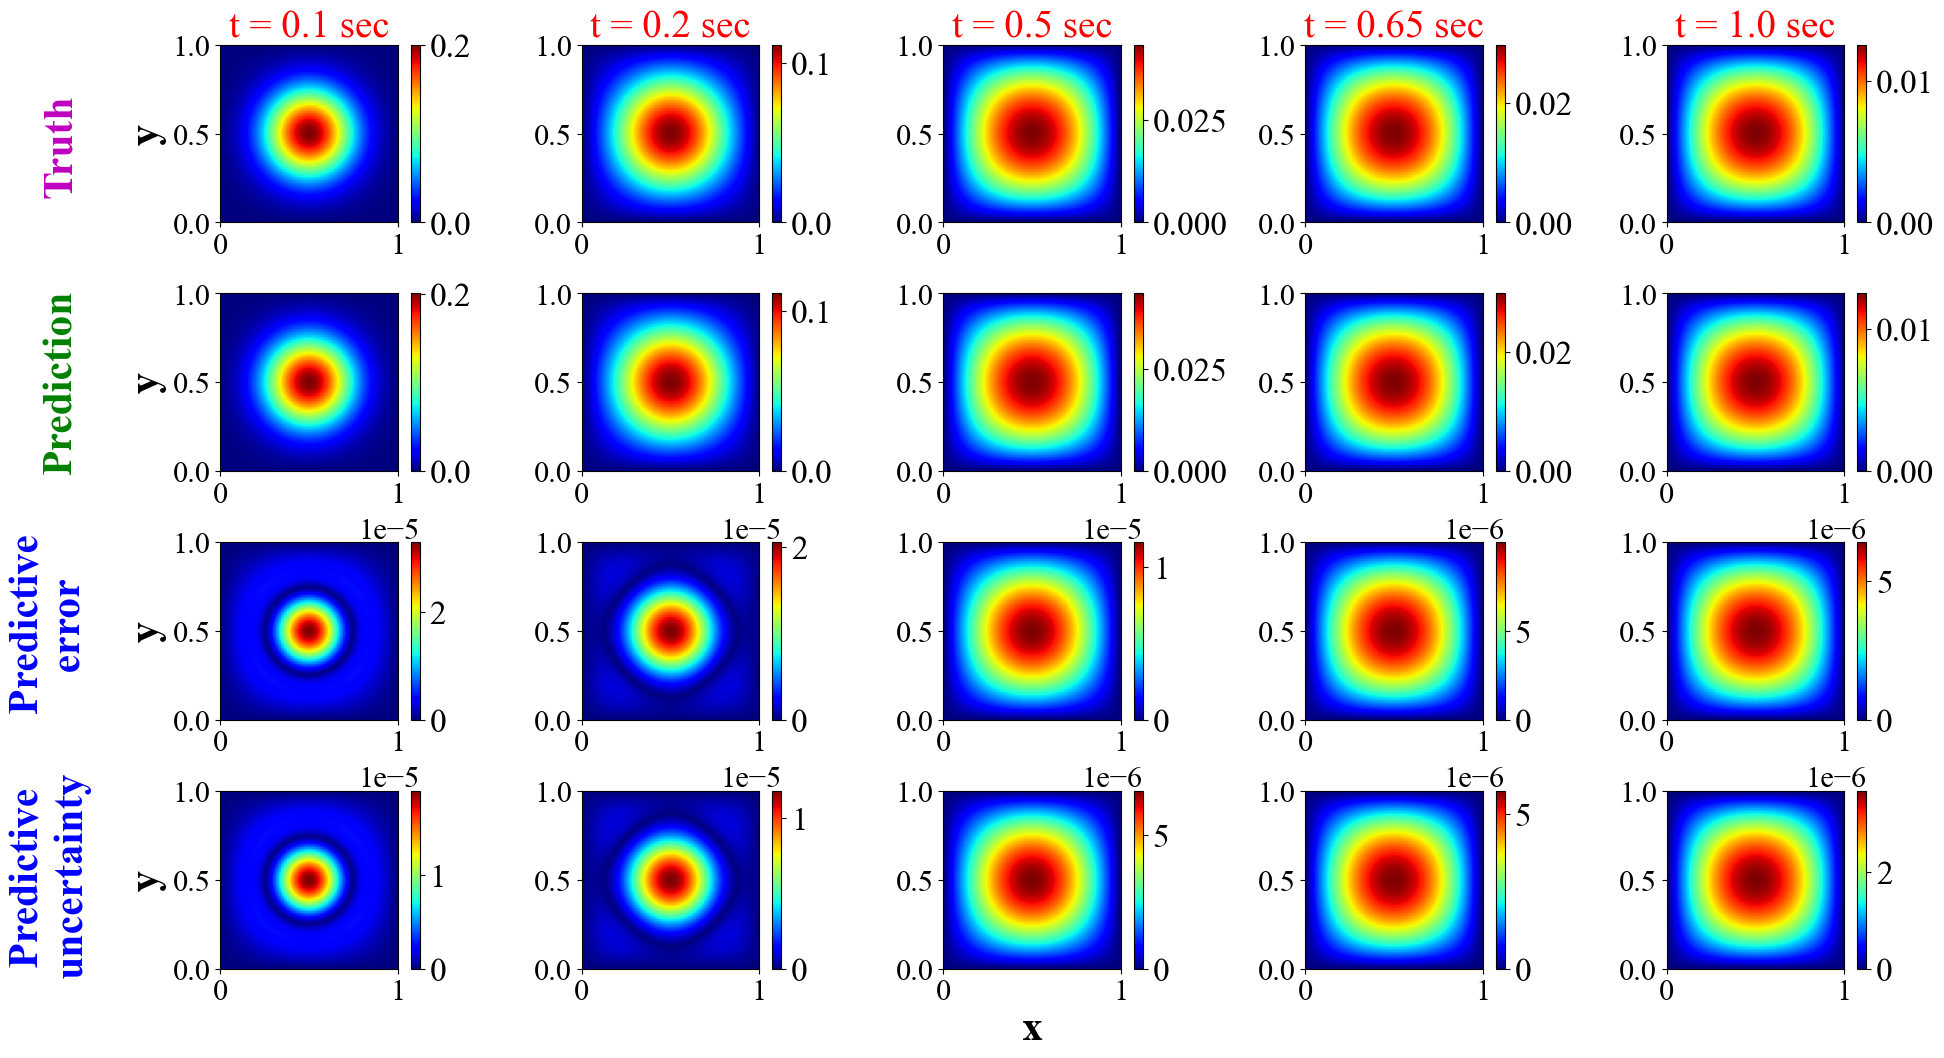

In [49]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 22

fig1 = plt.figure(figsize=(22, 12))
fig1.text(0.055,0.11,' Predictive\nuncertainty', rotation=90, fontweight='bold', color='b', fontsize=30)
fig1.text(0.055,0.33,'Predictive \n    error', rotation=90, fontweight='bold', color='b', fontsize=30)
fig1.text(0.07,0.53,'Prediction', rotation=90, fontweight='bold', color='g', fontsize=30)
fig1.text(0.07,0.76,'Truth', rotation=90, fontweight='bold', color='m', fontsize=30)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
num_steps = 1000
index = 0
for i in range(num_steps):
    if i == 99 or i == 199 or i == 499 or i == 649 or i == 999:
        plt.subplot(4, 5, index + 1)
        plt.imshow(U[i, :, :], origin='lower', cmap='jet', extent=[0, 1, 0, 1])
#         plt.xlabel('x', fontweight='bold', fontsize=30)  # Increase the font size
        if index == 0: 
            plt.ylabel('y', fontweight='bold', fontsize=30)  # Increase the font size        
        plt.title('t = {} sec'.format(i*0.001 + 0.001), color='red', fontsize=28)  # Increase the font size
        colorbar = plt.colorbar(fraction=0.045)
        colorbar.ax.tick_params(labelsize=24)  # Increase the font size of the colorbar values
        
        plt.subplot(4, 5, index + 6)
        plt.imshow(mu_pred[i, :, :], origin='lower', cmap='jet', extent=[0, 1, 0, 1])
#         plt.xlabel('x', fontweight='bold', fontsize=30)  # Increase the font size
        if index == 0:
            plt.ylabel('y', fontweight='bold', fontsize=30)  # Increase the font size
        colorbar = plt.colorbar(fraction=0.045)
        colorbar.ax.tick_params(labelsize=24)
        
        plt.subplot(4, 5, index + 11)
        plt.imshow(np.abs(U[i, :, :] - mu_pred[i, :, :]), origin='lower', cmap='jet', extent=[0, 1, 0, 1])
#         plt.xlabel('x', fontweight='bold', fontsize=30)  # Increase the font size
        if index == 0:
            plt.ylabel('y', fontweight='bold', fontsize=30)  # Increase the font size
        colorbar = plt.colorbar(fraction=0.045)
        colorbar.ax.tick_params(labelsize=24)
        
        
        plt.subplot(4, 5, index + 16)
        plt.imshow(std_pred[i, :, :], origin='lower', cmap='jet', extent=[0, 1, 0, 1])
        if index == 2:
            plt.xlabel('x', fontweight='bold', fontsize=30)  # Increase the font size
        if index == 0:
            plt.ylabel('y', fontweight='bold', fontsize=30)  # Increase the font size
        colorbar = plt.colorbar(fraction=0.045)
        colorbar.ax.tick_params(labelsize=24)  # Increase the font size of the colorbar values
        
        index = index + 1
plt.show()

fig1.savefig('images/2D_Heat_pred.pdf', bbox_inches='tight')